# Enhanced spatio-temporal electric load forecasts with less data using active deep learning
---


## Content overview 

1. Data processing
2. Prediction model
3. Active learning

An effective way to oppose global warming and mitigate climate change is to electrify our energy sectors and supply their electric power from renewable wind and solar. Spatio-temporal predictions of electric load become increasingly important for planning this transition, while deep learning prediction models provide increasingly accurate predictions for it. The data used for training deep learning models, however, is usually collected at random using a passive learning approach. This naturally results in a large demand for data and associated costs for sensors like smart meters, posing a large barrier for electric utilities in decarbonizing their grids. Here, we investigate if electric utilities can instead use active deep learning for collecting a more informative subset of candidate data by leveraging additional computation for better distributing smart meters. We find that even more accurate predictions are feasible with much less data when using active learning compared to when using passive learning.

---

## File overview

* src: folder containing the source code for jupyter notebooks and python scripts
* tests: folder containing unit tests for source code
* data: folder containing required (public) data for running experiments
* results public: folder containing published experimental results on original datasets
* images: folder containing images for this readme and the manuscript
* Docker: repository containing a Dockerfile for running hypothesis test inside a docker container
* DockerNotebook: repository containing a Dockerfile for running notebooks inside a docker container
* DockerUnittests: repository containing a Dockerfile for running unit tests inside a docker container
* src/main.py: main file for running experiments and reproducing numerical results
* src/hyperparameters.py: module for choosing all hyper parameters of experiments
* src/data.py: module for processing data 
* src/prediction.py: module for building, training and testing prediction models
* src/activelearning.py: implementation of feature embedding active learning and passive learning
* src/addexperiments.py: additional experiments like sequence importance and various heuristics
* src/plotresults.py: functions for plotting results in Jupyter notebook sessions.
* src/prep_data.py: functions for preparing datasets in Jupyter notebook sessions.
* src/prp_figures.py: functions for preparing manuscript figures in Jupyter notebook sessions.
* src/saveresults.py: functions for saving experimental results.
* src/vis_results.py: functions for visualizing main and heuristic experimental results.
* src/vis_addresults.py: functions for visualizing additional results like exemplar predictions.
* src/main_notebook.ipynb: Jupyter notebook session for reproducing method and experiments setepwise
* src/results_notebook.ipynb: Jupyer notebook sessions for plotting and analysing experimental results
* tests/test_prediction.py: unit tests for prediction.py
* tests/test_vis_results.py: unit tests for vis_results.py
---

## Docker 

Download this repository to your home directory, change your current working directory to this repository, and build main docker container by running:

`
cd
git clone https://github.com/ArsamAryandoust/DataSelectionMaps
cd DataSelectionMaps
docker build -t main Docker
`

For CPU computation, run:

`docker run -v ~/DataSelectionMaps:/DataSelectionMaps main`

For GPU support, make sure you have the nvidia-container-toolkit installed, then run:

`docker run --gpus all -v ~/DataSelectionMaps:/DataSelectionMaps main`

**Note:** If you download this repository to a location other than your home directory, make sure it is at a sub-directory of your home directory and replace all ~/DataSelectionMaps with ~/path/to/subdirectory/DataSelectionMaps in the commands, i.e.

`docker run -v ~/path/to/subdirectory/DataSelectionMaps:/DataSelectionMaps main`


`docker run --gpus all -v ~/path/to/subdirectory/DataSelectionMaps:/DataSelectionMaps main`

---

## Jupyter notebooks with docker

For running jupyter notebook sessions inside a docker container, run:

`docker build -t main_notebook DockerNotebook`

For CPU computation, run:

`docker run -it -v ~/DataSelectionMaps:/DataSelectionMaps -p 3333:1111 main_notebook`

For GPU support, make sure you have the nvidia-container-toolkit installed, and run:

`docker run -it --gpus all -v ~/DataSelectionMaps:/DataSelectionMaps -p 3333:1111 main_notebook`

Next, open localhost:3333 in your browser and type in the token from your terminal as password to run Jupyter notebook sessions inside the docker container from your browser.

**Note:** If you download this repository to a location other than your home directory, make sure it is at a sub-directory of your home directory and replace all ~/ActiveLearning with ~/path/to/subdirectory/ActiveLearning in the commands, i.e.

`docker run -it -v ~/path/to/subdirectory/DataSelectionMaps:/DataSelectionMaps -p 3333:1111 main_notebook`


`docker run -it --gpus all -v ~/path/to/subdirectory/DataSelectionMaps:/DataSelectionMaps -p 3333:1111 main_notebook`

---

## Unit tests with docker

For running unittests for the implemented active learning algorithm inside a docker container, run:

`docker build -t tests DockerUnittests`

For CPU computation, run:

`docker run -v ~/DataSelectionMaps:/DataSelectionMaps tests`

For GPU support, make sure you have the nvidia-container-toolkit installed, then run:

`docker run --gpus all -v ~/DataSelectionMaps:/DataSelectionMaps tests`

**Note:** If you download this repository to a location other than your home directory, make sure it is at a sub-directory of your home directory and replace all ~/DataSelectionMaps with ~/path/to/subdirectory/DataSelectionMaps in the commands, i.e.

`docker run -v ~/path/to/subdirectory/DataSelectionMaps:/DataSelectionMaps tests`


`docker run --gpus all -v ~/path/to/subdirectory/DataSelectionMaps:/DataSelectionMaps tests`

---

We start with importing a number of packages that we need for implementing our feature embedding active learning algorithm, and define a number of hyper parameters that are bundled through the use of attributes of a class object *HyperParameter* in the file **hyperparameters.py**.

In [1]:
### Package imports and computation environment setup ###

import gc
import os
import random
import math
import numpy as np

# decide which GPU(s) should be seen by CUDA before importing tf.
# Choose '-1' for calculation on CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf

# tell us how many GPUS are visible to CUDA and tensorflow
print(
    'Num GPUs Available: ', 
    len(tf.config.experimental.list_physical_devices('GPU'))
)

# Import application source code
import hyperparameters
import data
import prediction
import activelearning
import saveresults
import plotresults


# Set a randomization seed for better reproducability of results,
# or None for avoiding any possible effect on experiments
seed = 3

if seed is not None:

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Set seed for tf weight initialzers
    random_normal = tf.keras.initializers.RandomNormal(
        mean=0.0, 
        stddev=0.05, 
        seed=seed
    )
    random_uniform = tf.keras.initializers.RandomUniform(
        minval=-0.05, 
        maxval=0.05, 
        seed=seed
    )
    truncated_normal = tf.keras.initializers.TruncatedNormal(
        mean=0.0, 
        stddev=0.05, 
        seed=seed
    )
    glorot_normal = tf.keras.initializers.GlorotNormal(
        seed=seed
    )
    glorot_uniform = tf.keras.initializers.GlorotUniform(
        seed=seed
    )
    orthogonal = tf.keras.initializers.Orthogonal(
        gain=1.0, 
        seed=seed
    )
    variance_scaling = tf.keras.initializers.VarianceScaling(
                       scale=1.0, 
                       mode='fan_in', 
                       distribution='truncated_normal', 
                       seed=seed
    )

# class instance that contains all our hyperparameters
HYPER = hyperparameters.HyperParameter(random_seed=seed)

Num GPUs Available:  1
If you do not own the private data, your experiment will not succeed in private access mode! Change hyper parameter to PUBLIC_ACCESS=True


## 1 Data processing

In this section, we create training, validation and testing datasets which are ready to be processed by the deep learning models that we will create in the next section. First, we import our underlying label and feature data. Our labels are building-scale electric consumption profiles. Our features are high resolution aerial images of these buildings and the meteorlogical conditions at these buildings. Next, we build feature label pairs from these raw data and further add the timestamps at which electric consumption values are measured as another feature to each of our data points. We then proceed with normalizing our data, splitting it for training, validation and testing, and eventually standardizing all datasets with the statistics (mean and standard deviation of features) of the training data. 

We start with creating two new class objects: first, *RawData*, which we use to bundle paths to where our data is stored and miscellaneous other useful values; second, *Dataset*, which we use to bundle vectors of time variant (X_t), space variant (X_s, X_s1) and space-time variant (X_st) features, as well as their corresponding labels (Y). Classes and functions that we introduce in this section are defined in **data.py**.

In [2]:
raw_data = data.RawData(HYPER)

### 1.1 Building-scale electric consumption profiles

The electric consumption profiles that we use are measured in 15-min time steps. Each day hence has 96 values. Each year respectively has 35,040 values. The profiles are mostly added up from single sub profiles, so as to eventually represent the total consumption of the corresponding building, and not only of distinct entities inside each building, such as several apartments inside the same building. Each building and its corresponding load profile is identified through a building ID, a cluster ID and a year ID which we import and save separately for all of these profiles. The plots below show the profiles of exmeplar buildings. The x-axes represent the timestamp in which the electric consumption is measured, and the y-axes the electric power consumption in kilo Watt (hours) [kW/kWh]. 

Importing consumption profiles
1/1 [==============================] - 0s 414ms/step
The 92 imported electric load profiles demand a total amount of 0.02606976 GB of RAM


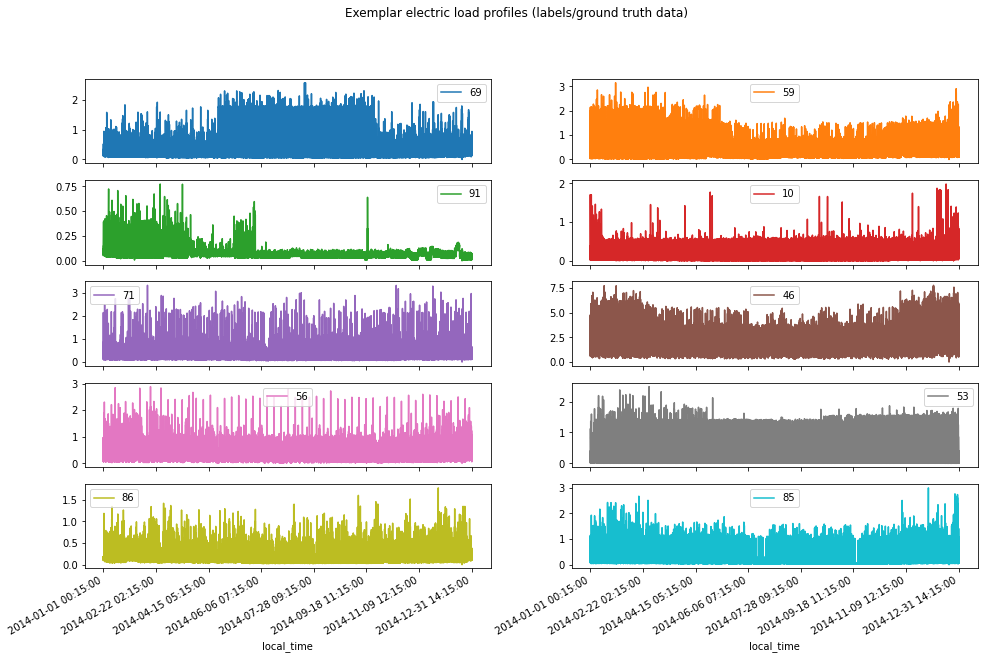

In [3]:
raw_data = data.import_consumption_profiles(HYPER, raw_data)

### 1.2 Building-scale aerial imagery

For each building whose electric consumption profile we loaded, we further import an aerial image that is cropped to an excerpt from that building only. Images are padded with zero values (black) on their empty borders so as to all have the same size. Here, we also perform the optional down sampling and grey scaling of images. For each imported building image, we further keep track of their corresponding building IDs so as to be able to assign these to each other during further data processing or during training, validation and testing of our prediction model.

Importing building-scale aerial imagery:
92/92 [==============================] - 0s 4ms/step
The 92 aerial images demand 0.2053969919999995 GB RAM with float32 entries


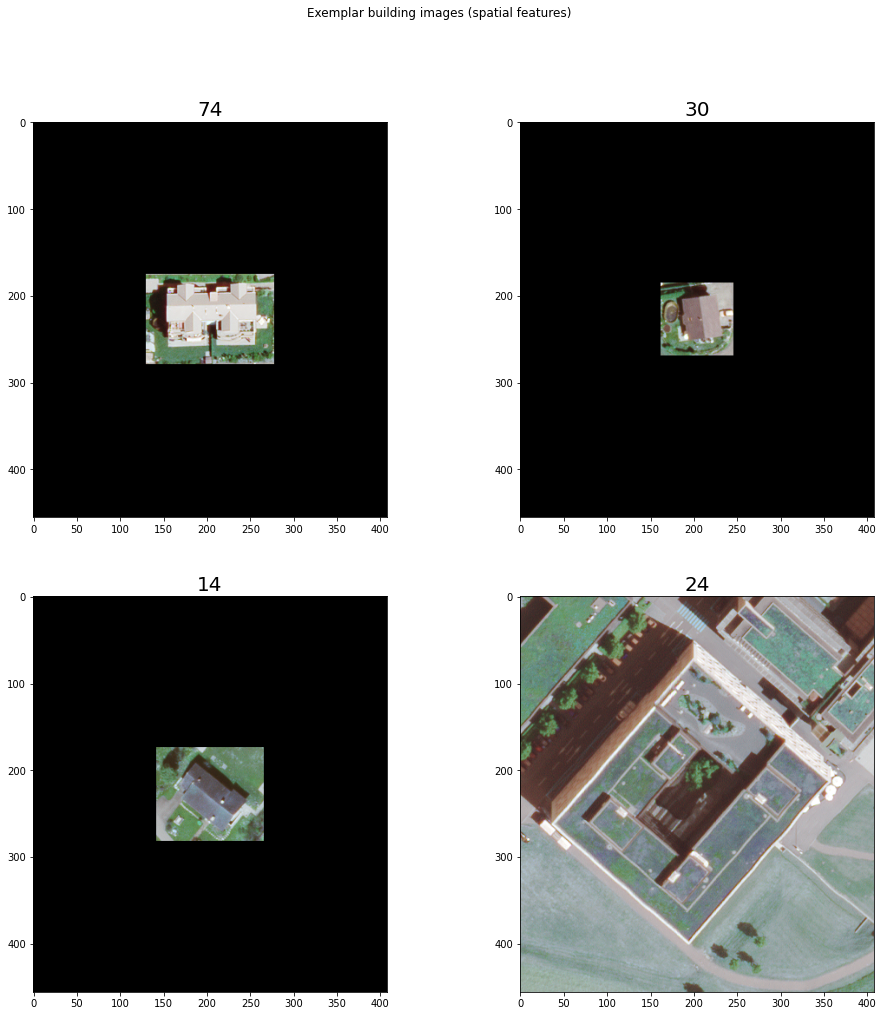

In [4]:
raw_data = data.import_building_images(HYPER, raw_data)

### 1.3 Cluster-scale meteorological data

Buildings that are in a maximum distance of one kilo meter (km) to each other belong to the same cluster. Instead of using meteorological data for each individual building, we use meteorological data for each cluster. This significantly reduces our data demand for meteorological data without any relevant loss of accuracy. Here, we import the meteorological data for each cluster and keep track of the cluster IDs for each imported dataset. The resolution of these measurements is hourly. The number of past data points that we use for each data point is determined through hyper parameters. The plot below shows all meteorological conditions that we import and consider as features for an exemplar cluster ID. These are air density, cloud cover, precipitation, solar irradiance on the surface, solar irradiance on the atmosphere, snow mass, snowfall, temperature and wind speed. The x-axes represents the timestamp in which the meteorological conditions are measured, and the y-axes the respective values in their various respective units. These values consist of air density in kg/m³, cloud cover, precipitation in mm/hour, ground level solar irradiance in W/m², top of atmosphere solar irradiance W/m², air temperature in °C, snowfall in mm/hour, snow mass in kg/m² and wind speed.

Importing meteorological data
11/11 [==============================] - 1s 46ms/step
The 11 meteo data files demand 0.030835199999999993 GB RAM


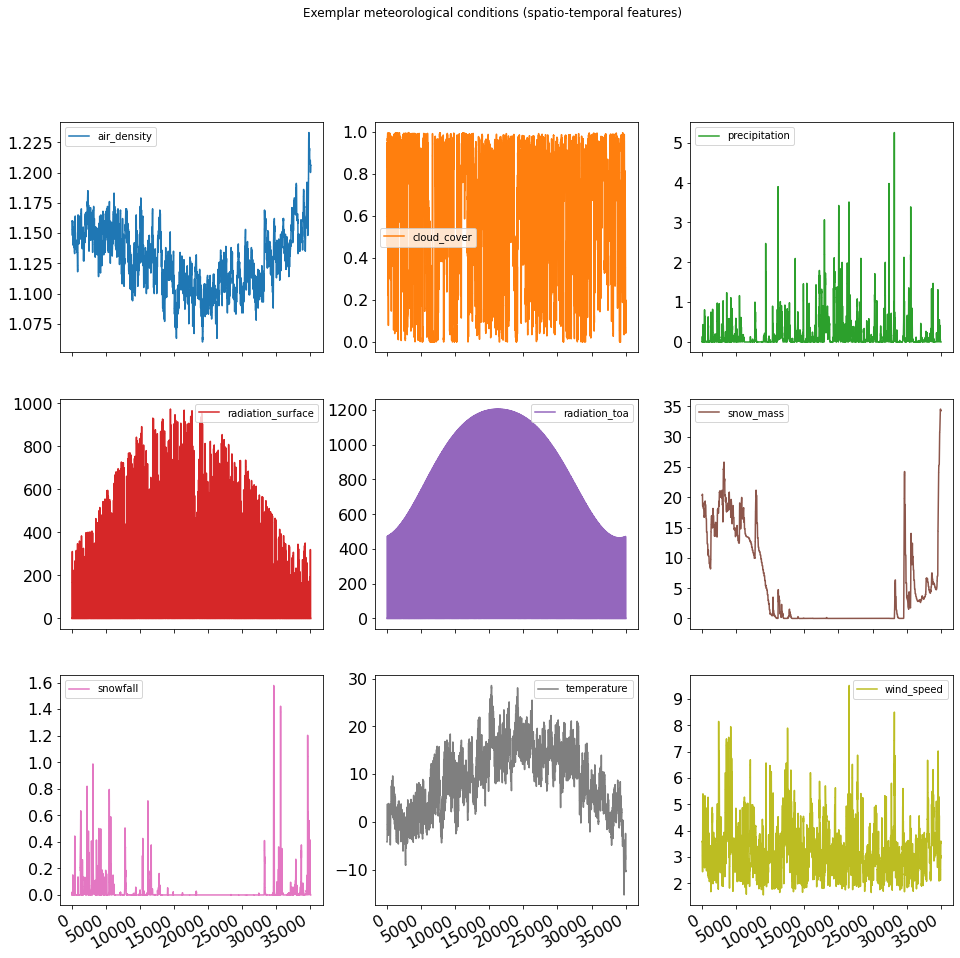

In [5]:
raw_data = data.import_meteo_data(HYPER, raw_data)

### 1.4 Feature-label pairing

For each timestamp in which electric consumption and meteorological measurements match, and for each building, we create a unique data point consisting of features and labels. Here, we further add the timestamp distinguished by the year, month, day, hour and quarter hour as a feature to each data point. Therefore, each data point consists of a time variant feature vector X_t (timestamp), a space variant feature vector X_s (building ID), a space-time variant feature vector X_st (meteorological data) and a label vector Y (electric consumption). We bundle these as attributes of an object instance of the previously created *Dataset* class.

Note: At this stage we do not replicate images for each data point as this would unnecessarily increase our memory demand. Instead, we only save the building ID as spatial feature of each data point so as to be able to load images during training, without the need to replicate images multiple times for each data point. 

In [6]:
dataset, raw_data = data.create_feature_label_pairs(HYPER, raw_data)

Creating feature label data pairs:
16192/16192 [==============================] - 10s 635us/step


### 1.5 Encode temporal features

Our time variant features consist of five dimensions: year, month, day, hour and quarter of hour. We need to express these features in more useful numbers. Here, we can do this through ordinal encoding for each dimension separately, or an ordinal encoding merged into a single dimension, or through one-hot-encoding. Depending on many other hyper parameters that we set, any of these can bring the best performance for predictions and the learning process of our neural networks. However, one-hot-encoded features have the largest and hence ideally avoided increase in memory demand. For our application, distinguished ordinal encoding of each dimension is a good choice.

In [7]:
dataset = data.encode_time_features(HYPER, dataset)

Encoding temporal features
X_t before: [0. 1. 2. 1.]
X_t after: [0 1 1 0] (ORD)


### 1.6 Normalize all features

It is often useful to normalize each feature to values between 0 and 1. This helps to prevent vanishing and exploding gradients when updating the weights of our neural network prediction model through backpropagation and gradient descent. The importance of this becomes particularly clear if we look at the different scales at which meteorological data is provided. Each meteorological condition has a distinct unit and hence a largely different scale than all other values, although being part of the same feature vector. Here, we normalize features by each of their feature dimensions, as if these were flattened feature vectors. 

In [8]:
dataset = data.normalize_features(HYPER, raw_data, dataset)

Normalizing features


### 1.7 Split into training, validation and testing data

Given our entire data, we want to split it into subsets for training, validation and testing of our prediction models. While models like random forest do not need a separate validation dataset, and can use the concept of out-of-bag error instead, the validation dataset is important when training neural network prediction models. At the same time, we cannot use the same validation dataset, which is used during training of our neural network to see whether generalization improves or not, as a reliable testing dataset, as we fit our neural network models such that they perform particularly well on the validation data through concepts like early stopping. Hence we somehow also fit our model to performing well on this validation data. Here we split our data according to the shares that are defined through our hyper parameters. The output below shows the shares into which we split our entire data. 

Note: We distinguish between temporal, spatial and spatio-temporal predictions. Temporal predictions mean that we want to predict the electric consumption for the same building for which a sensor is placed, but for a time period into the past or future, for which we do not have measured data available. Spatial predictions mean that we want to predict electric consumption for buildings in which a sensor is not placed, but for a time period in which we do have measurements available from other buildings. Spatio-temporal predictions respectively refer to the most difficult problem of predicting the electric consumption for times and buildings, for which we do not have any measurements available at all.

In [9]:
(
    training_data, 
    validation_data, 
    testing_data
) = data.split_train_val_test(HYPER, raw_data, dataset)

Splitting data into training, validation and testing sets.
With TRAIN_SPLIT = 0.5  and TEST_SPLIT = 0.5 the data is split in the following ratio:
------------------------------------------------------------------------------------------------------------------
Training data:   2024 (12%)
Validation data: 2024 (12%)
Testing data:    12144 (75%)
------------------------------------------------------------------------------------------------------------------
Spatial testing data:         4048 (33%)
Temporal testing data:        4048 (33%)
Spatio-temporal testing data: 4048 (33%)


### 1.8 Standardize features

We can only guarantee the convergence of our neural network model and speed up its training if we standardize our training data, meaning that we create a zero mean and unit variance for each of its distinct feature dimensions. We do this by first flattening all our input dimensions and then calculating the statistics that are required to perform this transformation. Next we perform the same transformation on all other validation and testing datasets with the statistics of our training data.

Note: All testing and validation datasets are transformed according to the statistics of the training data, not with respect to their own statistics as this would lead to differently transformed feature values and corrupt inference and validation. Furthermore, it is important that the statistics for performing standardization are calculated not on the entire data, but only based on the training data as only this is seen by the neural network during training and needs to be guaranteed to converge. 

In [10]:
# Note: it is important that training data is
# converted last as it is the reference for the rest
testing_data = data.standardize_features(
    HYPER, 
    raw_data, 
    testing_data, 
    training_data, 
    silent=True
)
validation_data = data.standardize_features(
    HYPER, 
    raw_data, 
    validation_data, 
    training_data, 
    silent=True
)
training_data = data.standardize_features(
    HYPER, 
    raw_data, 
    training_data, 
    training_data, 
    silent=True
)

## 2 Prediction model

In this section, we create baseline predictions using a random forest prediction model, and then create, train and test our embedding network prediction model. The embedding network model that we define is a modular neural network and each module is used as an encoder for embedding features for the subsequent active learning task. We start with defining a new class object *EncodersAndPredictors* for bundling our main prediction model and its encoder sub-networks. We further set the loss metric according to whether we solve our prediction task as a regression or a classification model. In the latter case we use a sparse categorical cross entropy loss instead of a mean square error. In both cases we choose to take the mean of each prediction step error as our total error, and a free but unpublished optimizer called *RMSprop* for training our weights. Classes and functions that we introduce in this section are defined in **prediction.py**.

In [11]:
# initialize optimization parameters
(
    loss_object, 
    optimizer, 
    loss_function, 
    mean_loss
) = prediction.initialize_optimizer(HYPER)

### 2.1 Baseline

In order to see how well we predict with any chosen constellation of problem setup and neural network design, we create a random forest regressor as our baseline predictor. Random forest regressors are fast to train and powerful predictors at the same time. Another major advantage of this decision-tree based prediction model is that we do not have any hyper parameters to tune: the number and depth of trees can be as large as we can computationally afford, and the optimal number of randomly chosen features for creating each tree is known to be $\sqrt{D}$ (with theoretical guarantees), where $D$ is the dimension of our entire feature vector. As a rule of thumb, we can say that once we beat this predictor, we are on a good way to work ourselves forward to a useful deep learning prediction model. In addition to this, we can use the number of node activations of the random forest to make statements about the importance of features. The plots below illustrate the feature importance that are calculated in this way, and exemplar predictions for each available dataset. The x-axis of each plot describes the 15-min time steps into the future from a given timestamp, and the y-axis the corresponding electric consumption of a given building at these times in kW/kWh.

Note: The evaluation of predictions on our training dataset is not used for any validation, but to see whether our model learns useful patterns, or whether it under- or overfits to the training data. 

The out-of-bag validation score for random forest is: 0.6980262058353421
Loss on training data:                                0.03723817691206932
Loss on validation data:                              0.28930115699768066
Loss on spatio-temporal testing data:                 1.672257423400879


/DataSelectionMaps/src/prediction.py:258: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize=16,
/DataSelectionMaps/src/prediction.py:258: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize=16,
/DataSelectionMaps/src/prediction.py:258: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize=16,


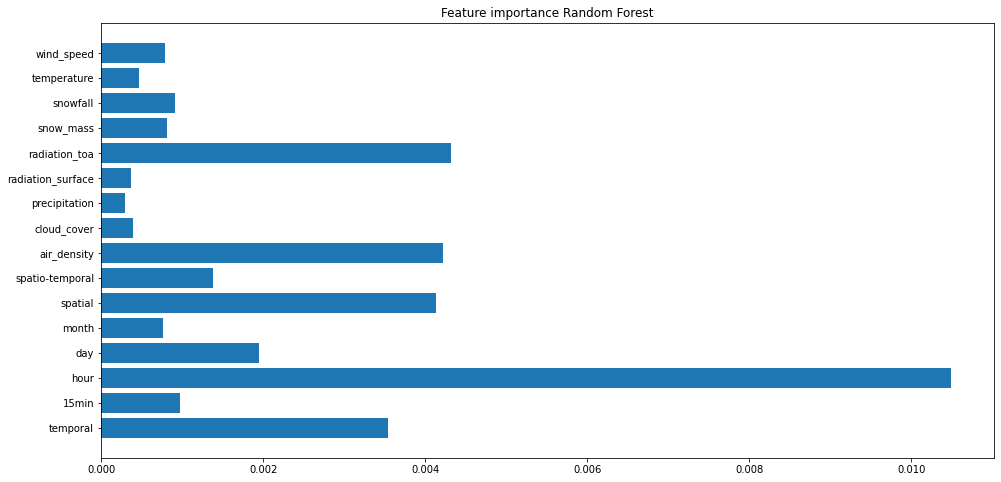

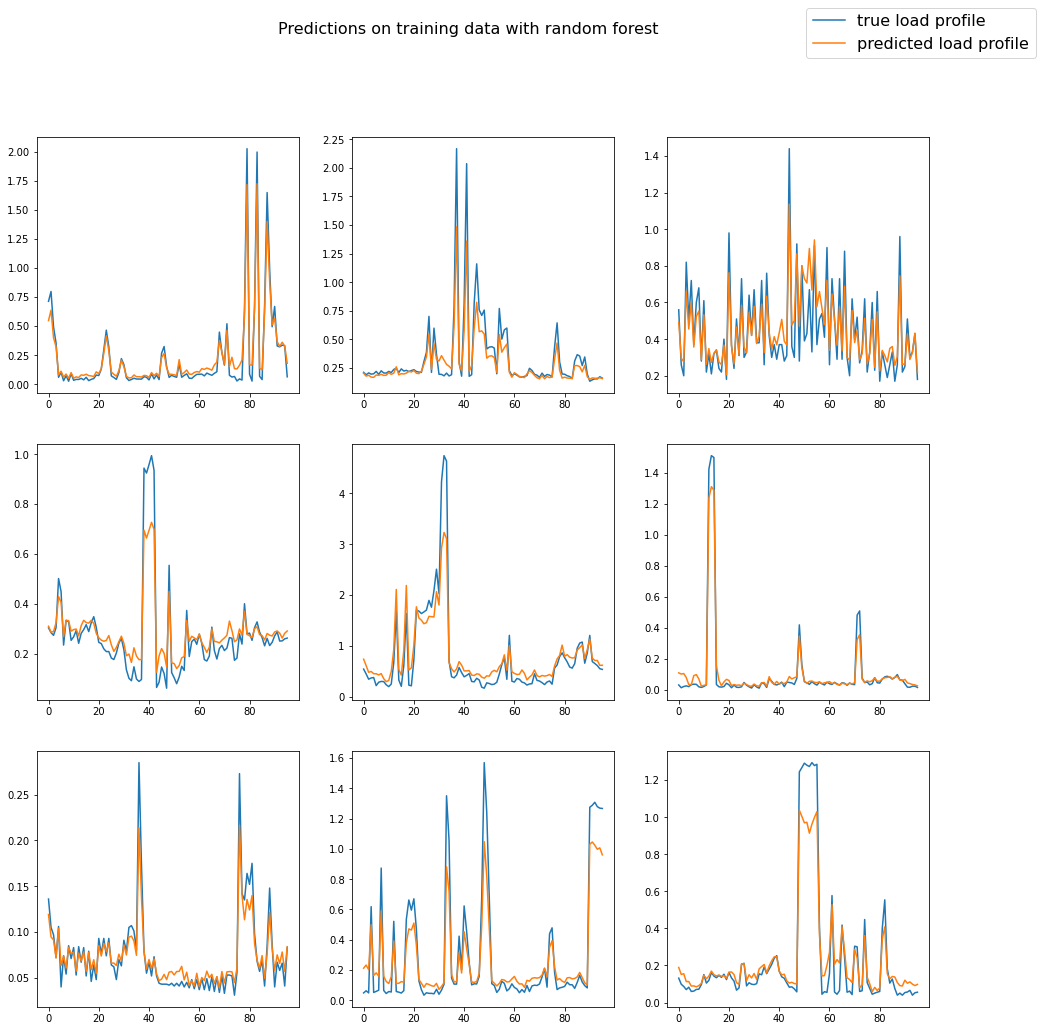

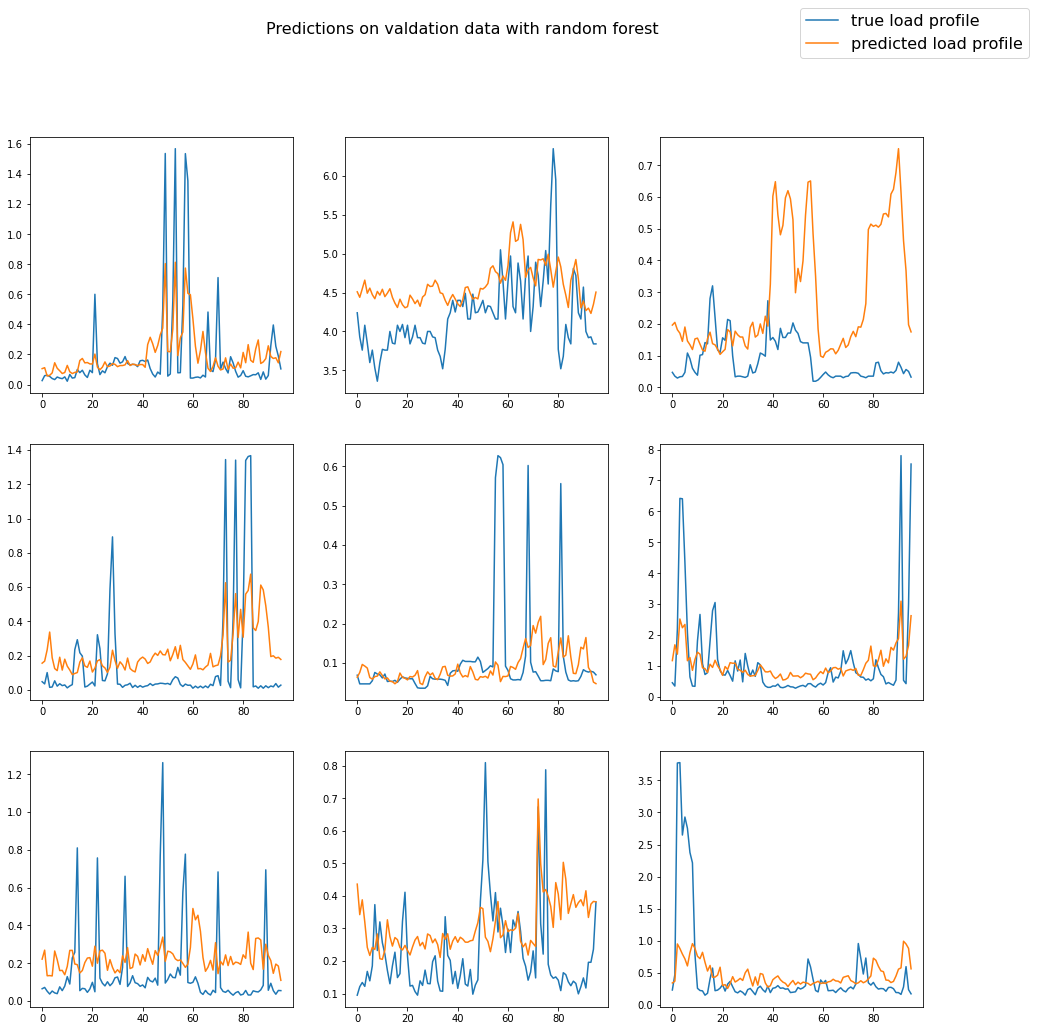

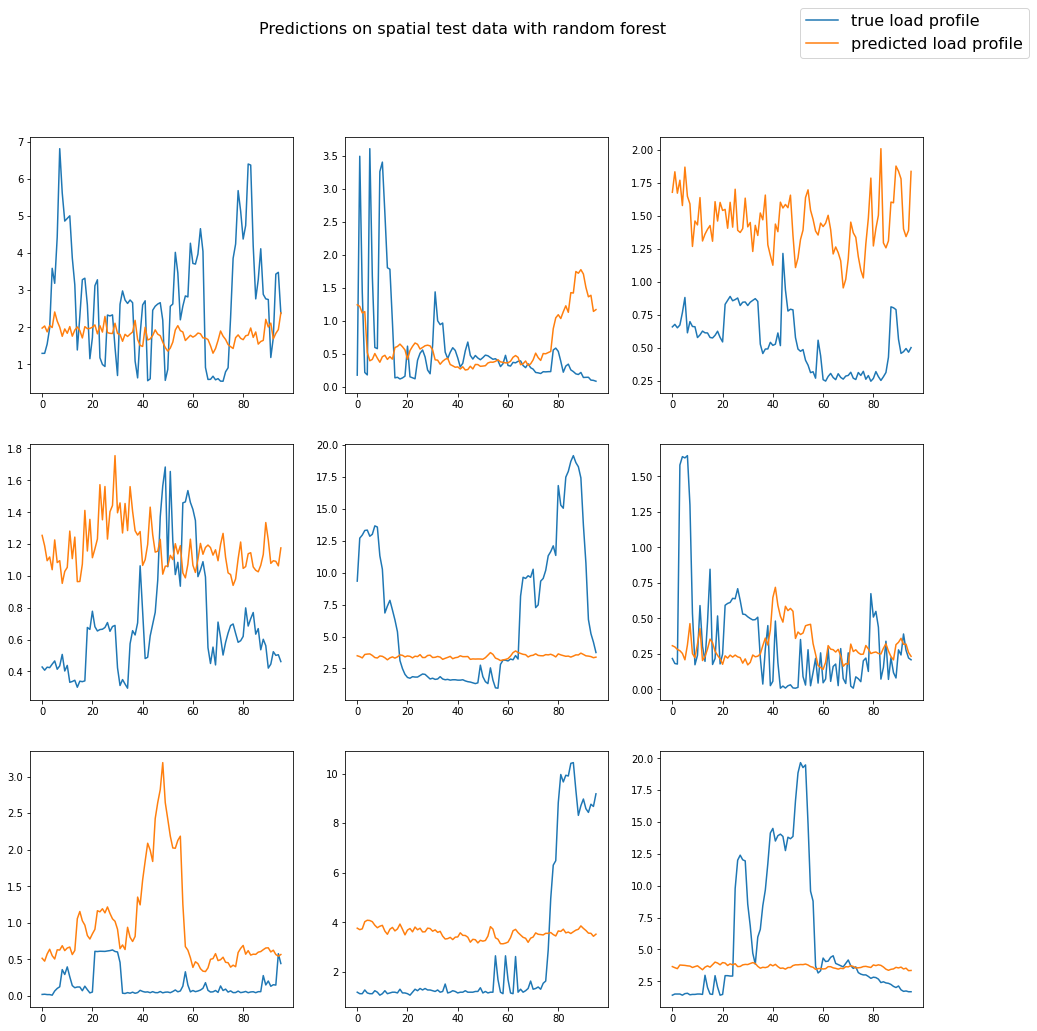

In [14]:
# train a random forest model
RF_regr = prediction.create_and_train_RF(HYPER, training_data)

# make predictions
train_pred = prediction.predict_with_RF(
    HYPER, 
    RF_regr, 
    training_data
)
val_pred = prediction.predict_with_RF(
    HYPER, 
    RF_regr, 
    validation_data
)
test_pred = prediction.predict_with_RF(
    HYPER, 
    RF_regr, 
    testing_data
) 
    
# Calculate the loss on each prediction
mean_loss.reset_states()
train_l = mean_loss(
    loss_function(
        training_data.Y, 
        train_pred
    )
).numpy()

mean_loss.reset_states()
val_l = mean_loss(
    loss_function(
        validation_data.Y, 
        val_pred
    )
).numpy()

mean_loss.reset_states()
test_l = mean_loss(
    loss_function(
        testing_data.Y, 
        test_pred
    )
).numpy()


RF_result = test_l
    
# Tell us the out of bag validation score and prediction losses
print(
    'The out-of-bag validation score for random forest is: {}'.format( 
        RF_regr.oob_score_
    )
)
print(
    'Loss on training data:                                {}'.format(
        train_l
    )
)
print(
    'Loss on validation data:                              {}'.format(
        val_l
    )
)
print(
    'Loss on {} testing data:                 {}'.format(
        HYPER.PRED_TYPE_ACT_LRN, test_l
    )
)



###
# Visualize predictions and feature importance ###
###

# call feature importance plotting function
prediction.plot_RF_feature_importance(
    HYPER, 
    raw_data, 
    RF_regr.feature_importances_, 
    training_data
)

# call prediction comparison plotting function
prediction.plot_true_vs_prediction(
    'Predictions on training data with random forest', 
    training_data.Y, 
    train_pred
)
prediction.plot_true_vs_prediction(
    'Predictions on valdation data with random forest', 
    validation_data.Y, 
    val_pred
)
prediction.plot_true_vs_prediction(
    'Predictions on spatial test data with random forest', 
    testing_data.Y, 
    test_pred
)

# delete the model as it occupies a large amount of memory
del RF_regr
_ = gc.collect()

### 2.2 Definition

Here, we build our embedding network prediction model with an architecture that can be set through a number of hyper parameters. The model summary below contains the tensor shapes of each layer of our model, and the number of its trainable weights/parameters. The subsequent computational graphs then show the constellation of each module of our network, which we will refer to as feature encoders. The last graph shows the entire prediction model built from all these modules. 

Building prediction model
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_t (InputLayer)                [(None, 4)]          0                                            
__________________________________________________________________________________________________
X_s1 (InputLayer)               [(None, 100, 3)]     0                                            
__________________________________________________________________________________________________
X_st (InputLayer)               [(None, 24, 9)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1000)         5000        X_t[0][0]                        
__________________________________________________________________

None

Computation graph for X_t_encoder:


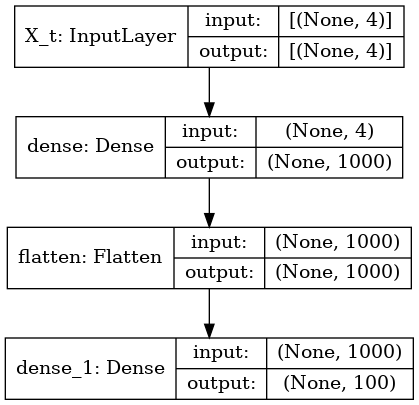

---------------------------------------------------------------------------------------------------------


None

Computation graph for X_s1_encoder:


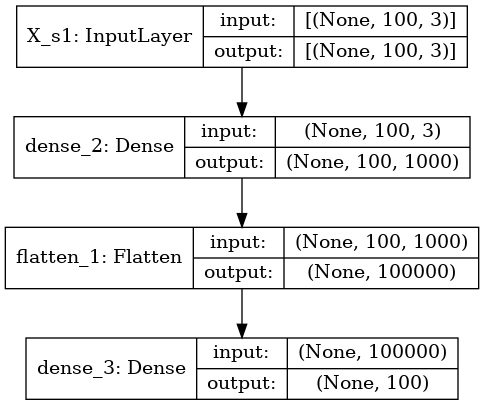

---------------------------------------------------------------------------------------------------------


None

Computation graph for X_st_encoder:


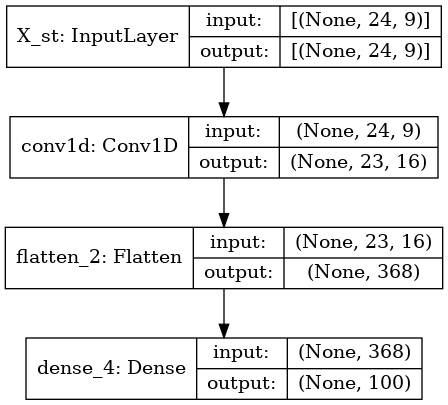

---------------------------------------------------------------------------------------------------------


None

Computation graph for X_joint_encoder:


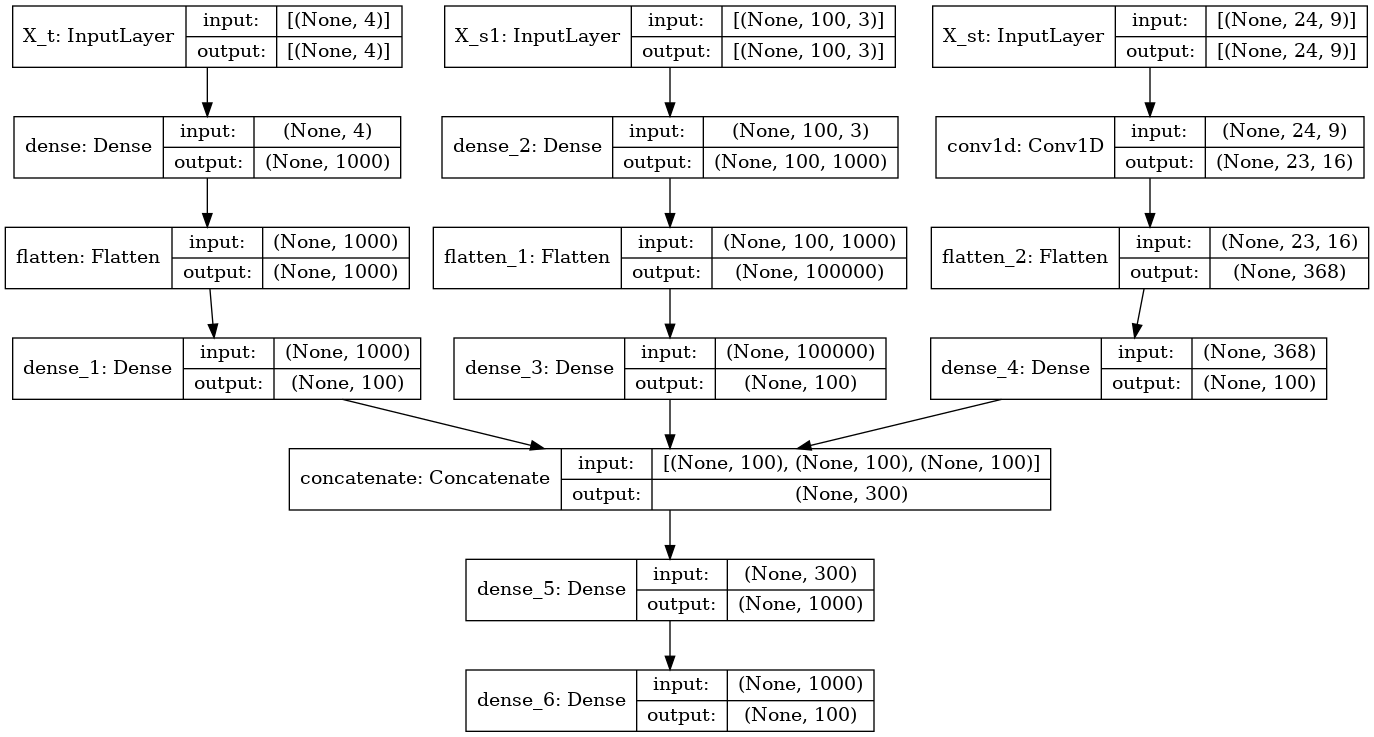

---------------------------------------------------------------------------------------------------------


None

Computation graph for prediction_model:


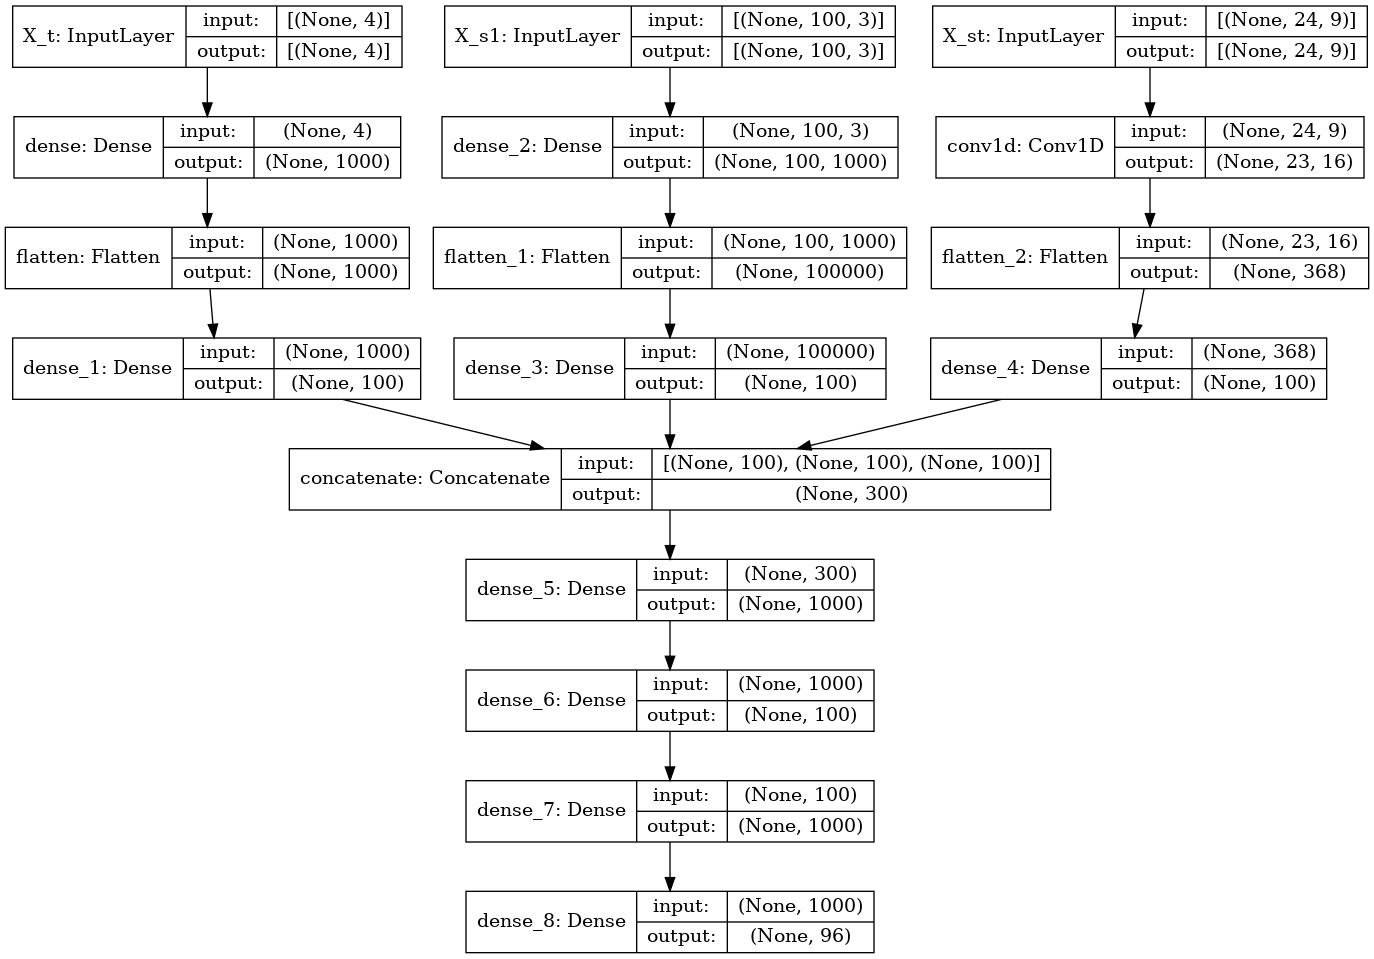

---------------------------------------------------------------------------------------------------------


In [15]:
models = prediction.build_prediction_model(
    HYPER, 
    raw_data, 
    training_data
)

### 2.3 Training

Here, we use our training dataset to learn a functional relationship between our features on the one side and our labels on the other side. We use the functional API of the tensorflow deep learning framework to do this. The plot below illustrates the training and validation loss history (y-axis) for each epoch of training (x-axis). An epoch stands for an entire iteration over the available (randomly sequenced) training dataset.

Note: All details of the training process can be seen in the src/**hyperparameters.py** file where we set hyper parameters. 

Epoch 1/30
Training:
126/125 [==============================] - 4s 4ms/step - loss: 0.8564
Validation:
126/125 [==============================] - 0s 2ms/step - loss: 0.3532
Epoch 2/30
Training:
126/125 [==============================] - 1s 4ms/step - loss: 0.3956
Validation:
126/125 [==============================] - 0s 2ms/step - loss: 0.3445
Epoch 3/30
Training:
126/125 [==============================] - 1s 4ms/step - loss: 0.3382
Validation:
126/125 [==============================] - 0s 2ms/step - loss: 0.3132
Epoch 4/30
Training:
126/125 [==============================] - 1s 4ms/step - loss: 0.3168
Validation:
126/125 [==============================] - 0s 2ms/step - loss: 0.3180
Epoch 5/30
Training:
126/125 [==============================] - 1s 4ms/step - loss: 0.2800
Validation:
126/125 [==============================] - 0s 2ms/step - loss: 0.3690
Epoch 6/30
Training:
126/125 [==============================] - 1s 4ms/step - loss: 0.2693
Validation:
126/125 [=======================

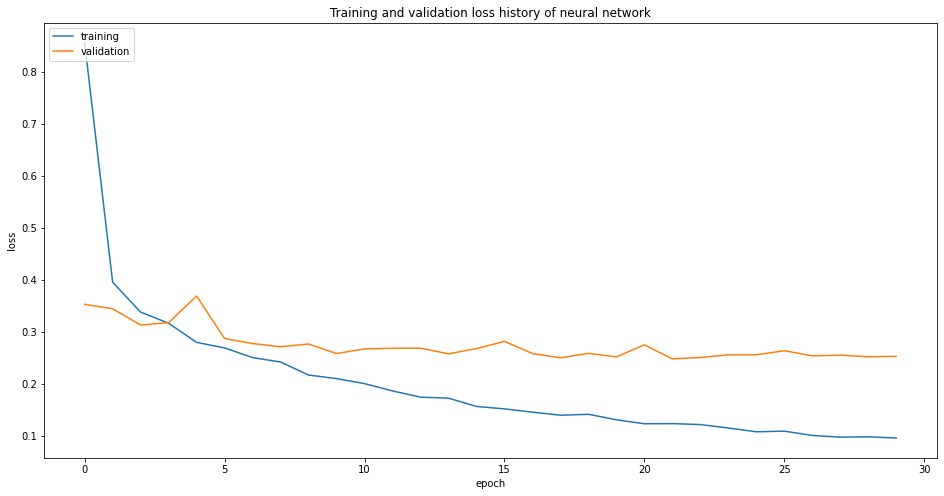

In [16]:
# Call training and saving functions
train_loss_hist, val_loss_hist = prediction.train_model(
    HYPER, 
    models.prediction_model, 
    training_data, 
    validation_data, 
    raw_data,
    loss_object, 
    optimizer, 
    mean_loss,
    plot=True,
    silent=False
)
prediction.save_prediction_model(
    HYPER, 
    raw_data, 
    models.prediction_model, 
    'initial'
)
prediction.save_encoder_and_predictor_weights(
    HYPER, 
    raw_data, 
    models
)

### 2.4 Testing

We calculate the prediction error of our trained model on all available datasets and plot exemplar predictons for each of these. The x-axis of each plot describes the 15-min time steps into the future from a given timestamp, and the y-axis the corresponding electric consumption of a given building at these times in kW/kWh.

Note: Again, the evaluation of the training and validation datasets merely serve for a comparision to our random forest baseline predictor and for seeing whether we are able to learn useful patterns, underfit or overfit. 

Training data loss: 0.08662298


/DataSelectionMaps/src/prediction.py:258: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize=16,


Validation data loss: 0.2543656


/DataSelectionMaps/src/prediction.py:258: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize=16,


Testing data loss: 2.206843


/DataSelectionMaps/src/prediction.py:258: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize=16,


2.206843

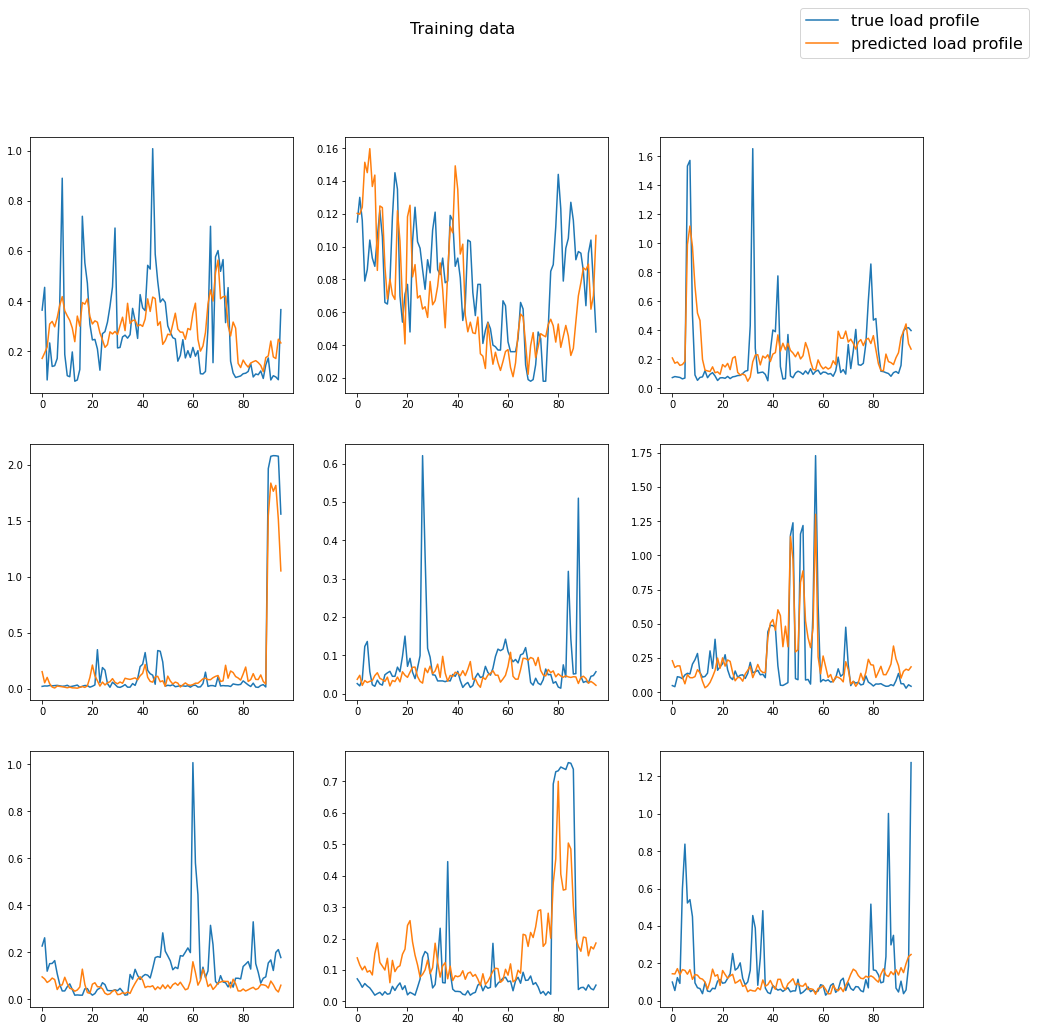

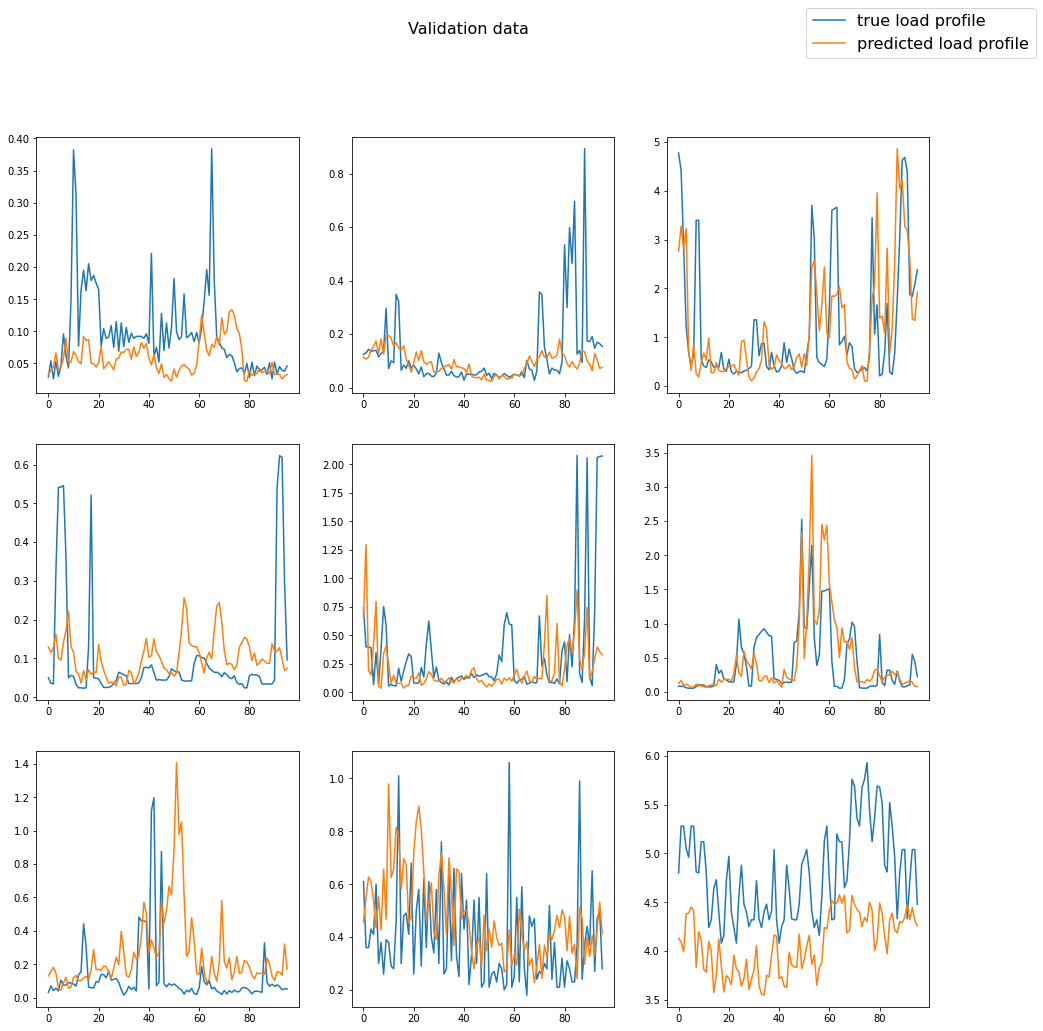

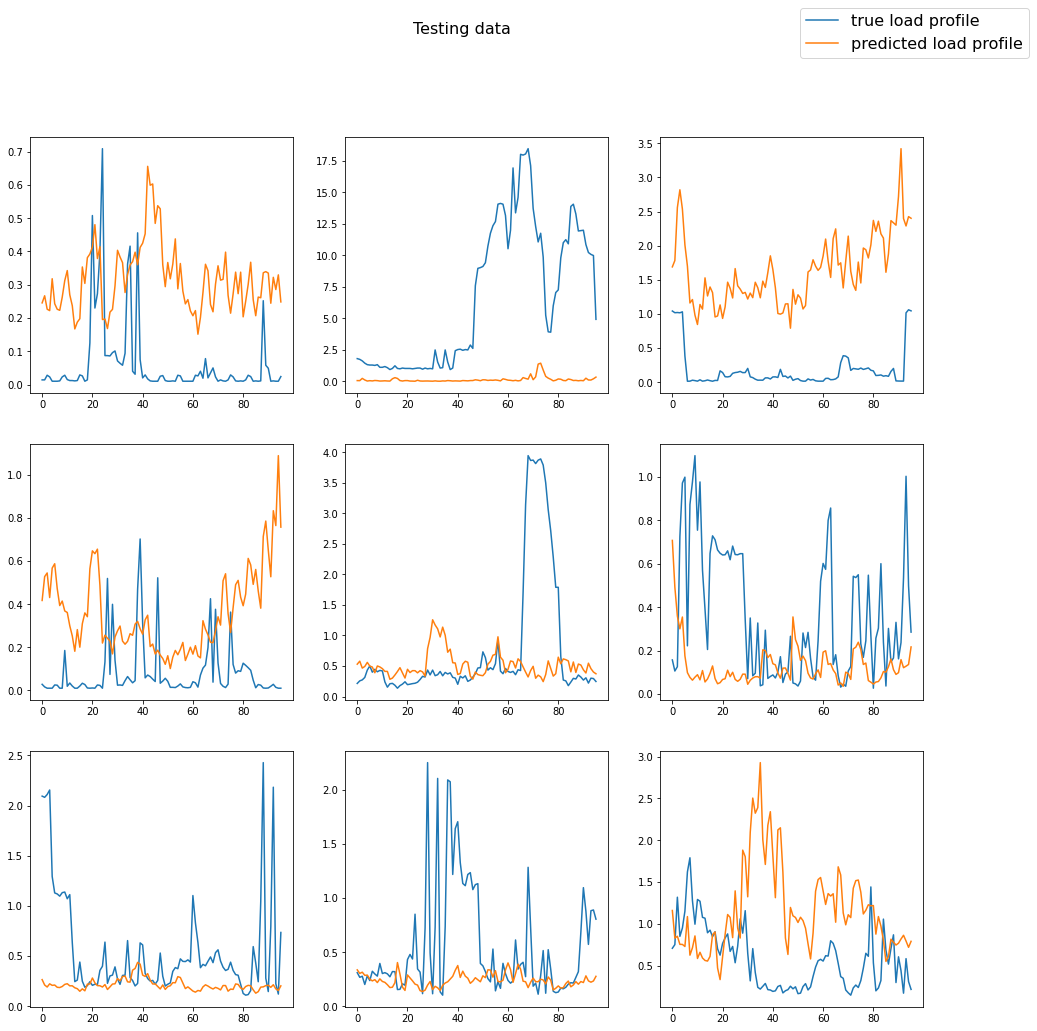

In [17]:
prediction.test_model(
    HYPER, 
    'Training data', 
    models.prediction_model, 
    training_data, 
    raw_data,
    mean_loss, 
    loss_function, 
    silent=False, 
    plot=True
)
prediction.test_model(
    HYPER, 
    'Validation data', 
    models.prediction_model, 
    validation_data, 
    raw_data,
    mean_loss, 
    loss_function, 
    silent=False, 
    plot=True
)
prediction.test_model(
    HYPER, 
    'Testing data', 
    models.prediction_model, 
    testing_data, 
    raw_data,
    mean_loss, 
    loss_function, 
    silent=False, 
    plot=True
)

## 3. Active learning

In this section, we develop our pool-based batch active learning method. First, we encode the features of candidate data points into an embedded vector space using an embedding network that is trained on initially available data points. In this case, the initially available data is our training dataset. Second, we cluster candidate data points based on their vector distances to each other in the encoded space. Third, we calculate the distance of each data embedded candidate data point to its cluster center to express our metric of informativeness. We make queries according to different metrices using these distances. We start with creating a new class object *ActLrnResults* which bundles all the results for each of the active learning variants that we evaluate. Classes and functions that we introduce in this section are defined in **activelearning.py**.

In [18]:
# initialize hyper parameters for AL
HYPER.set_act_lrn_params()

# for demonstration, consider all possible query variables
query_variable_list = [
    'X_st', 
    'X_(t,s)', 
    'Y_hat_(t,s)', 
    'Y_(t,s)'
]

### 3.1 Encode features

We use the encoders that were previously trained alongside our prediction model to encode features into an embedded vector space. Each feature type (time, space and space-time variant) has its own encoder. All features together further have a joint encoder that can encode the respective feature vectors of each data point into an embedded vector space of some fixed dimension. The vector space into which each feature vector is embedded is defined through the last layer (embedding layer) of each encoder that we define through the architecture of our embedding network prediction model. 

In [19]:
available_index_set = set(
    np.arange(
        testing_data.n_datapoints
    )
)

encoding_list = []

for query_variable in query_variable_list:
    
    data_budget_total = math.floor(
        HYPER.DATA_BUDGET_ACT_LRN * testing_data.n_datapoints
    )
    
    data_budget_per_iter = math.floor(
        data_budget_total / HYPER.N_ITER_ACT_LRN
    )
    
    subsample_size = math.floor(
        data_budget_per_iter
        + HYPER.CAND_SUBSAMPLE_ACT_LRN * (
            len(available_index_set) 
            - data_budget_per_iter
        )
    )

    encoding, _ = activelearning.encode_features(
        HYPER, 
        raw_data, 
        models, 
        testing_data,
        available_index_set,
        subsample_size,
        query_variable, 
        silent=False
    )

    encoding_list.append(encoding)

Encoding features into embedded vector spaces for X_st
Encoding features into embedded vector spaces for X_(t,s)
Encoding features into embedded vector spaces for Y_hat_(t,s)
Encoding features into embedded vector spaces for Y_(t,s)


### 3.2 Compute clusters

In each encoded vector space, we can use the distances of encoded feature vectors to each other to compute clusters in our embedded data. The method that we use for clustering data points can be set through our hyper parameters which is the K-means++ algorithm here. 

In [20]:
l_list = []
c_list = []

for encoding in encoding_list:

    # create clusters
    labels, centers, n_clusters = activelearning.compute_clusters(
        HYPER, 
        encoding, 
        data_budget_per_iter, 
        silent=False
    )

    # add to lists
    l_list.append(labels)
    c_list.append(centers)

Creating clusters in encodings with n_clusters= 202
Creating clusters in encodings with n_clusters= 202
Creating clusters in encodings with n_clusters= 202
Creating clusters in encodings with n_clusters= 202


### 3.3 Compute distances

We can use the distance of each embedded data point (or its partial feature vectors) to its cluster center to express our metric of informativeness.

In [21]:
for index_var in range(len(query_variable_list)):

    encoding = encoding_list[index_var]
    cluster_labels = l_list[index_var]
    cluster_centers = c_list[index_var]
    similarity_array =  activelearning.compute_similarity(
        HYPER, 
        encoding, 
        cluster_labels, 
        cluster_centers, 
        silent=False
    )

Calculating distances
4048/4048 [==============================] - 1s 223us/step
Calculating distances
4048/4048 [==============================] - 1s 216us/step
Calculating distances
4048/4048 [==============================] - 1s 209us/step
Calculating distances
4048/4048 [==============================] - 1s 235us/step


### 3.4 Batching algorithm

In each iteration of our active learning algorithm, we query a batch of candidate data points. We evaluate the performance of our algorithm for each prediction type and compare these to a passive learning benchmark. For each prediction type, we evaluate data queries according to the embedding uncertainty of our respective feature vectors. We also evaluate the performance of our algorithm for the hypothetical case of using the true labels of candidates as query variable, representing the optimal priors that we can build on candidate data. The outputs below show information about the progress of a set of relevant values of our algorithm in each iteration.

Note: We plot our random forest baseline prediction losses (dashed red line) to see whether our models make reasonably good predictions or not.

prediction task:             spatio-temporal
AL variable:                 None
AL variant:                  PL
distance metric:             Laplacian
clustering method:           KMeans
data budget:                 2024/4048 (50%)
known sensors:               46
known streaming timestamps:  78
candidate sensors:           46
candidate timestamps:        88
---------
Iteration:                            0
Time:                                 6s
Trained on candidate batch size:      202
Used streaming times:                 78/88 (89%)
Used sensors:                         46/46 (100%)
Used data budget:                     202/2024 (10%)
---------
Iteration:                            1
Time:                                 6s
Trained on candidate batch size:      202
Used streaming times:                 88/88 (100%)
Used sensors:                         46/46 (100%)
Used data budget:                     404/2024 (20%)
---------
Iteration:                            2
Time:           

Iteration:                            5
Time:                                 13s
Trained on candidate batch size:      202
Used streaming times:                 88/88 (100%)
Used sensors:                         46/46 (100%)
Used data budget:                     1212/2024 (60%)
---------
Iteration:                            6
Time:                                 12s
Trained on candidate batch size:      202
Used streaming times:                 88/88 (100%)
Used sensors:                         46/46 (100%)
Used data budget:                     1414/2024 (70%)
---------
Iteration:                            7
Time:                                 12s
Trained on candidate batch size:      202
Used streaming times:                 88/88 (100%)
Used sensors:                         46/46 (100%)
Used data budget:                     1616/2024 (80%)
---------
Iteration:                            8
Time:                                 11s
Trained on candidate batch size:      202
Used s

---------
Iteration:                            0
Time:                                 34s
Trained on candidate batch size:      202
Used streaming times:                 81/88 (92%)
Used sensors:                         46/46 (100%)
Used data budget:                     202/2024 (10%)
---------
Iteration:                            1
Time:                                 34s
Trained on candidate batch size:      202
Used streaming times:                 86/88 (98%)
Used sensors:                         46/46 (100%)
Used data budget:                     404/2024 (20%)
---------
Iteration:                            2
Time:                                 30s
Trained on candidate batch size:      202
Used streaming times:                 88/88 (100%)
Used sensors:                         46/46 (100%)
Used data budget:                     606/2024 (30%)
---------
Iteration:                            3
Time:                                 29s
Trained on candidate batch size:      202
U

Iteration:                            6
Time:                                 29s
Trained on candidate batch size:      202
Used streaming times:                 88/88 (100%)
Used sensors:                         46/46 (100%)
Used data budget:                     1414/2024 (70%)
---------
Iteration:                            7
Time:                                 22s
Trained on candidate batch size:      202
Used streaming times:                 88/88 (100%)
Used sensors:                         46/46 (100%)
Used data budget:                     1616/2024 (80%)
---------
Iteration:                            8
Time:                                 24s
Trained on candidate batch size:      202
Used streaming times:                 88/88 (100%)
Used sensors:                         46/46 (100%)
Used data budget:                     1818/2024 (90%)
---------
Iteration:                            9
Time:                                 19s
Trained on candidate batch size:      202
Used s

---------
Iteration:                            0
Time:                                 48s
Trained on candidate batch size:      202
Used streaming times:                 75/88 (85%)
Used sensors:                         36/46 (78%)
Used data budget:                     202/2024 (10%)
---------
Iteration:                            1
Time:                                 40s
Trained on candidate batch size:      202
Used streaming times:                 88/88 (100%)
Used sensors:                         41/46 (89%)
Used data budget:                     404/2024 (20%)
---------
Iteration:                            2
Time:                                 41s
Trained on candidate batch size:      202
Used streaming times:                 88/88 (100%)
Used sensors:                         45/46 (98%)
Used data budget:                     606/2024 (30%)
---------
Iteration:                            3
Time:                                 39s
Trained on candidate batch size:      202
Use

Iteration:                            6
Time:                                 31s
Trained on candidate batch size:      202
Used streaming times:                 88/88 (100%)
Used sensors:                         42/46 (91%)
Used data budget:                     1414/2024 (70%)
---------
Iteration:                            7
Time:                                 32s
Trained on candidate batch size:      202
Used streaming times:                 88/88 (100%)
Used sensors:                         45/46 (98%)
Used data budget:                     1616/2024 (80%)
---------
Iteration:                            8
Time:                                 31s
Trained on candidate batch size:      202
Used streaming times:                 88/88 (100%)
Used sensors:                         46/46 (100%)
Used data budget:                     1818/2024 (90%)
---------
Iteration:                            9
Time:                                 26s
Trained on candidate batch size:      202
Used str

---------
Iteration:                            0
Time:                                 43s
Trained on candidate batch size:      202
Used streaming times:                 83/88 (94%)
Used sensors:                         12/46 (26%)
Used data budget:                     202/2024 (10%)
---------
Iteration:                            1
Time:                                 45s
Trained on candidate batch size:      202
Used streaming times:                 88/88 (100%)
Used sensors:                         17/46 (37%)
Used data budget:                     404/2024 (20%)
---------
Iteration:                            2
Time:                                 43s
Trained on candidate batch size:      202
Used streaming times:                 88/88 (100%)
Used sensors:                         23/46 (50%)
Used data budget:                     606/2024 (30%)
---------
Iteration:                            3
Time:                                 32s
Trained on candidate batch size:      202
Use

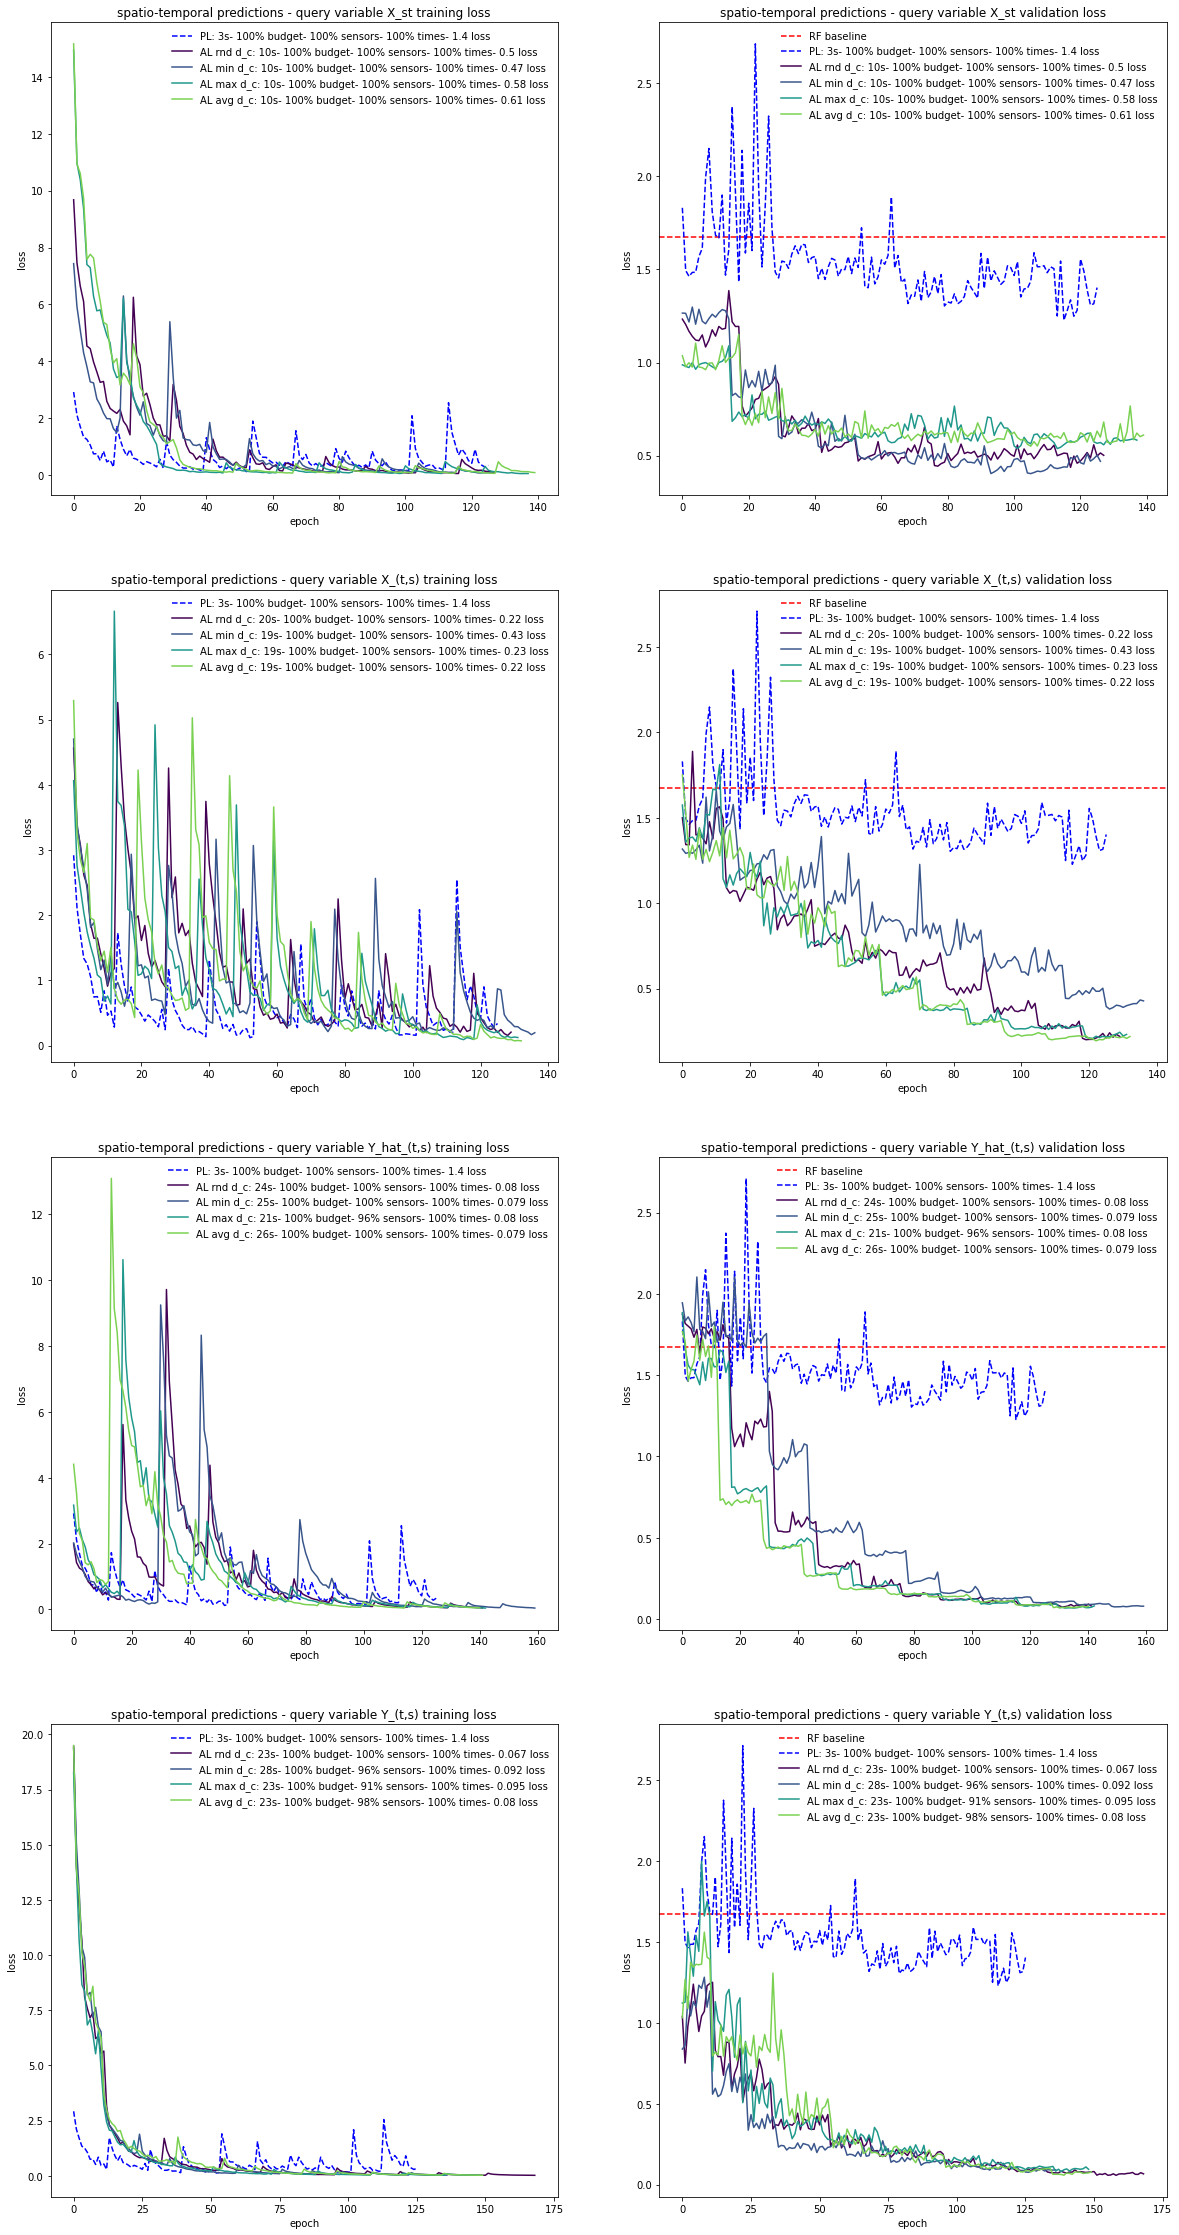

In [22]:
# initialize hyper parameters for AL
HYPER.set_act_lrn_params()

# create empty lists to add results
AL_result_list = []
PL_result_list = []

# create random result for benchmark once only for this pred_type
PL_result =  activelearning.feature_embedding_AL(
    HYPER, 
    models, 
    raw_data, 
    training_data, 
    testing_data, 
    loss_object, 
    optimizer, 
    mean_loss,  
    loss_function,
    'PL', 
    silent=False
)

# create empty list for saving results of corresponding AL variable
var_result_dict = {}

# iterate over all sort variables that are chosen to be considered
for query_variable in HYPER.QUERY_VARIABLES_ACT_LRN:

    # empty list for savings results of correspnding AL variant
    method_result_dict = {}

    # iterate over all methods that are chosen to be considered
    for method in HYPER.QUERY_VARIANTS_ACT_LRN:

        # test AL with currently iterated AL variable and variant
        AL_result =  activelearning.feature_embedding_AL(
            HYPER, 
            models, 
            raw_data, 
            training_data, 
            testing_data,
            loss_object, 
            optimizer, 
            mean_loss,  
            loss_function,
            method=method, 
            AL_variable=query_variable, 
            silent=False
        )

        # add results to method_result_list
        method_result_dict[method] = AL_result
     
    # add results to var_result_list
    var_result_dict[query_variable] = method_result_dict

# create result dictionary
results_dict = {
    'RF_result' : RF_result,
    'PL_result' : PL_result,
    'AL_result' : var_result_dict
}
    
# call visualization function for comparing train and validation results
plotresults.vis_train_and_val(
    HYPER, 
    results_dict
)